In [17]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

In [18]:
def PCA_soil_rotated(file_name, code, temporal_limits,n_components_sst=40, missing_value=0):
    sst = Data(file_name,code,temporal_limits, missing_value= missing_value)

    result = sst.get_data()
    lon_sst_list = sst.get_lon_list()
    lat_sst_list = sst.get_lat_list()
    lon = sst.get_lon()
    lat = sst.get_lat()
    
    lons = np.arange(lon[0],lon[-1],2)
    lats = np.arange(lat[0],lat[-1],-2)

    INDEX = []
    for i in range(len(lon_sst_list)):
        if (lon_sst_list[i] in lons) and (lat_sst_list[i] in lats):
            INDEX.append(i)
    
    result = result[:,INDEX]
    lat_sst_list = np.array(lat_sst_list)[INDEX]
    lon_sst_list = np.array(lon_sst_list)[INDEX]

    result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
    result_sst = signal.detrend(result_sst, axis=0)
    weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
    for i in range(len(weights)):
        result_sst[:,i] = weights[i] * result_sst[:,i]

    data_sst = pd.DataFrame(result_sst)
        
    V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)
        
    Vr, Rot = rung.varimax(V)
    Vr = rung.svd_flip(Vr)

    # Get explained variance of rotated components
    s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

    # matrix with diagonal containing variances of rotated components
    S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
    expvar = np.diag(S2r)

    sorted_expvar = np.sort(expvar)[::-1]
    # s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

    # reorder all elements according to explained variance (descending)
    nord = np.argsort(expvar)[::-1]
    Vr = Vr[:, nord]

    # Get time series of UNMASKED data
    comps_ts = np.matmul(np.array(data_sst),Vr)

    df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

    lon_temp = df_sst["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df_sst["lons"].vlues = lon_temp
    
    return(result_sst, comps_ts, Vr, df_sst, avgs, stds)

In [19]:
train_start = 1976
validation_end = 2010
n_components_soil = 40
f = 12

In [20]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}

In [37]:
sst = Data('../../../nc/soilw.mon.mean.v2.nc',"soilw",temporal_limits, missing_value= 0)

result = sst.get_data()
lon_list = sst.get_lon_list()
lat_list = sst.get_lat_list()
lon = sst.get_lon()
lat = sst.get_lat()

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/Data.py:36: RuntimeWarning: invalid value encountered in less
  self._mask = (var[:,:,-1]!= missing_value)
/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/Data.py:36: RuntimeWarning: invalid value encountered in greater
  self._mask = (var[:,:,-1]!= missing_value)
/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: RuntimeWarning: invalid value encountered in less
  return array(a, dtype, copy=False, order=order)
/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)


In [38]:
lons = np.arange(lon[0],lon[-1],2)
lats = np.arange(lat[0],lat[-1],-2)

In [39]:
index = []
for i in range(len(lon_list)):
    if (lon_list[i] in lons) and (lat_list[i] in lats):
        index.append(i)

In [40]:
result = result[:,index]
lat_list = np.array(lat_list)[index]
lon_list = np.array(lon_list)[index]

In [41]:
lon = lons
lat = lats

In [12]:
result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
result_sst = signal.detrend(result_sst, axis=0)
weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)

V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)


    V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)
        
    Vr, Rot = rung.varimax(V)
    Vr = rung.svd_flip(Vr)

    # Get explained variance of rotated components
    s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

    # matrix with diagonal containing variances of rotated components
    S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
    expvar = np.diag(S2r)

    sorted_expvar = np.sort(expvar)[::-1]
    # s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

    # reorder all elements according to explained variance (descending)
    nord = np.argsort(expvar)[::-1]
    Vr = Vr[:, nord]

    # Get time series of UNMASKED data
    comps_ts = np.matmul(np.array(data_sst),Vr)




Vr, Rot = rung.varimax(V)
Vr = rung.svd_flip(Vr)

# Get explained variance of rotated components
s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

# matrix with diagonal containing variances of rotated components
S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
expvar = np.diag(S2r)

sorted_expvar = np.sort(expvar)[::-1]
# s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

# reorder all elements according to explained variance (descending)
nord = np.argsort(expvar)[::-1]
Vr = Vr[:, nord]

# Get time series of UNMASKED data
comps_ts = np.matmul(np.array(data_sst),Vr)

df_sst = pd.DataFrame({"lons":lon_list,"lats":lat_list})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

IndentationError: unexpected indent (<ipython-input-12-2357372bea29>, line 12)

In [42]:
data_sst, ts, V, df_sst, avg, std = PCA_soil_rotated('../../../nc/soilw.mon.mean.v2.nc',"soilw",temporal_limits)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/Data.py:36: RuntimeWarning: invalid value encountered in less
  self._mask = (var[:,:,-1]!= missing_value)
/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/whole_data_validation/Data.py:36: RuntimeWarning: invalid value encountered in greater
  self._mask = (var[:,:,-1]!= missing_value)
/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: RuntimeWarning: invalid value encountered in less
  return array(a, dtype, copy=False, order=order)
/home/mathsys2/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)


In [152]:
data_sst - result_sst

ValueError: operands could not be broadcast together with shapes (420,94111) (420,5833) 

In [159]:
data_sst.shape

(420, 94111)

In [160]:
result_sst.shape

(420, 5833)

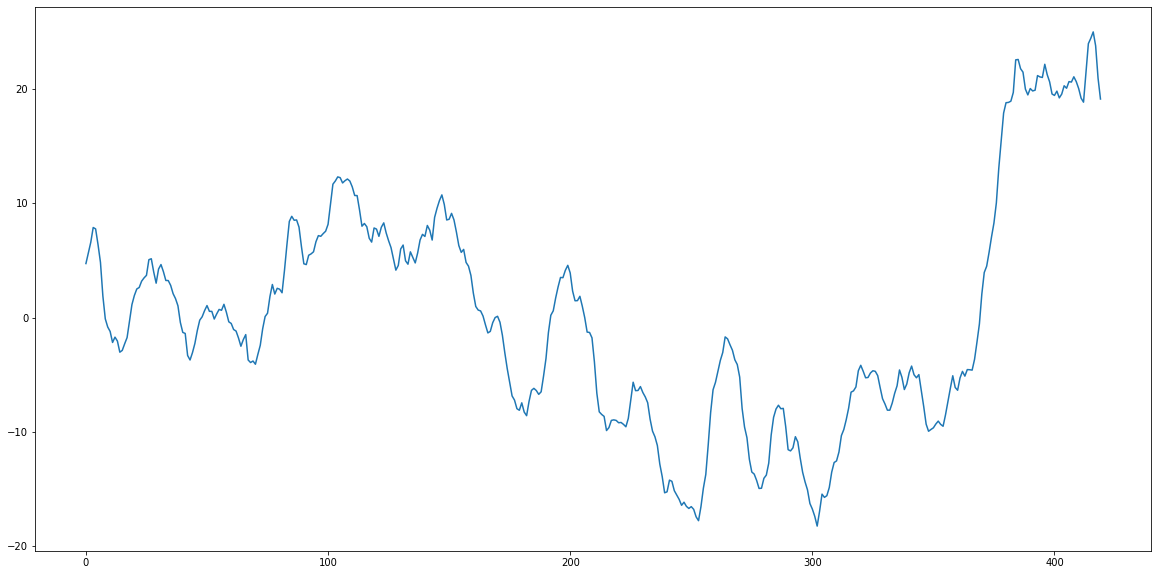

In [166]:
plt.plot(ts[:,0])

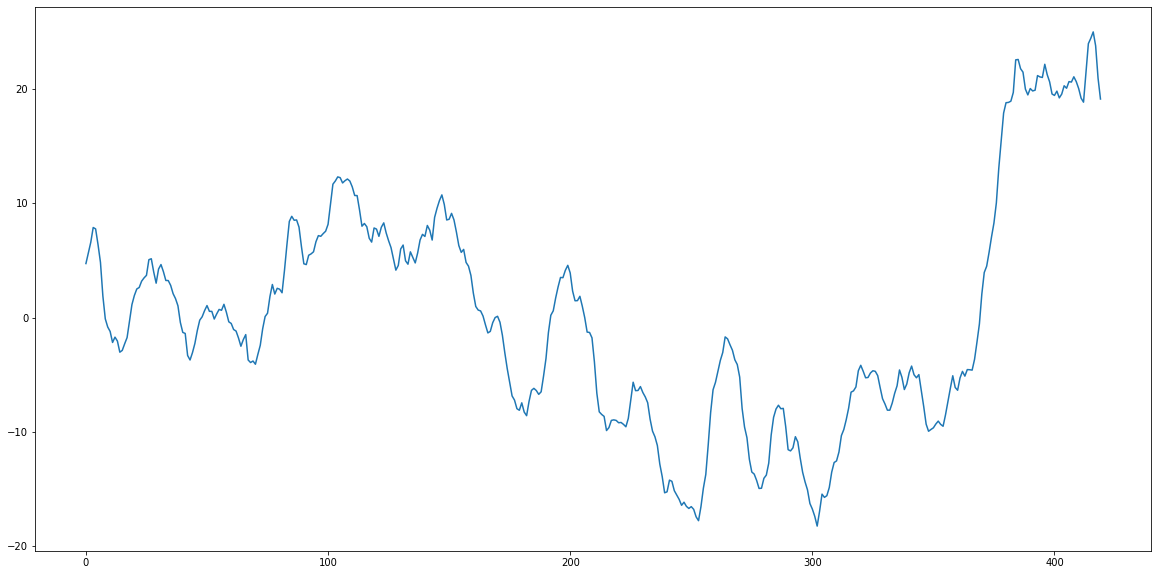

In [162]:
plt.plot(comps_ts[:,0])

In [18]:
tau = 6

In [19]:
pcmci = np.load("../../whole_data_results/ET_orac/best_link_soil/pcmci_{}_{}_{}_{}_{}.npy".format(f,train_start,validation_end,tau,n_components_soil))

In [20]:
pcmci

array([[ 13, -15],
       [ 32, -10],
       [ 40,  -8],
       [ 35,  -7],
       [  4, -16],
       [ 34, -12],
       [ 25, -17],
       [ 19, -17],
       [ 37,  -9],
       [ 26, -17]])

In [6]:
print(plt.cm.cmap_d.keys())

dict_keys(['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'Greens_r', 

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


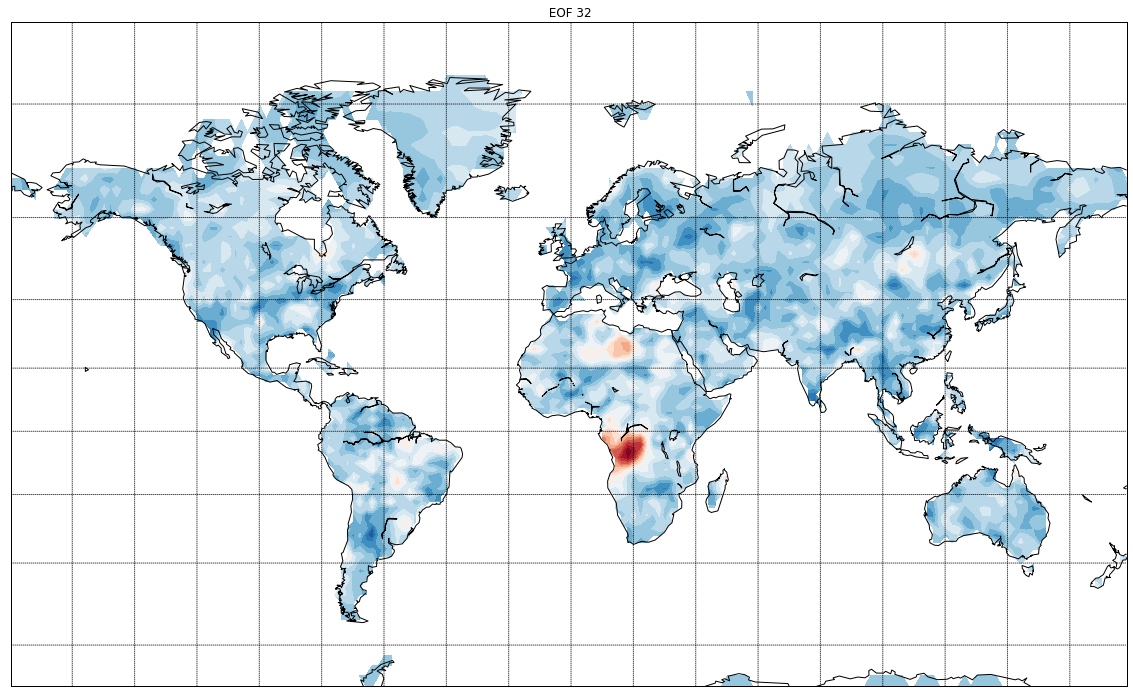

In [51]:
lon  = lon1
m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1.min(), \
  urcrnrlon=lon1.max(),llcrnrlat=lat.min()+20,urcrnrlat=lat.max(), \
  resolution='c')

lon2, lat2 = np.meshgrid(lon1,lat)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
cs = m.contourf(x,y,deg,20,cmap=plt.cm.get_cmap('RdBu_r'))
plt.title(' EOF {}'.format(pc))
#cbar.ax.tick_params(labelsize=25)
#plt.colorbar();
plt.savefig("SOIL_EOF{}1.png".format(pc))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


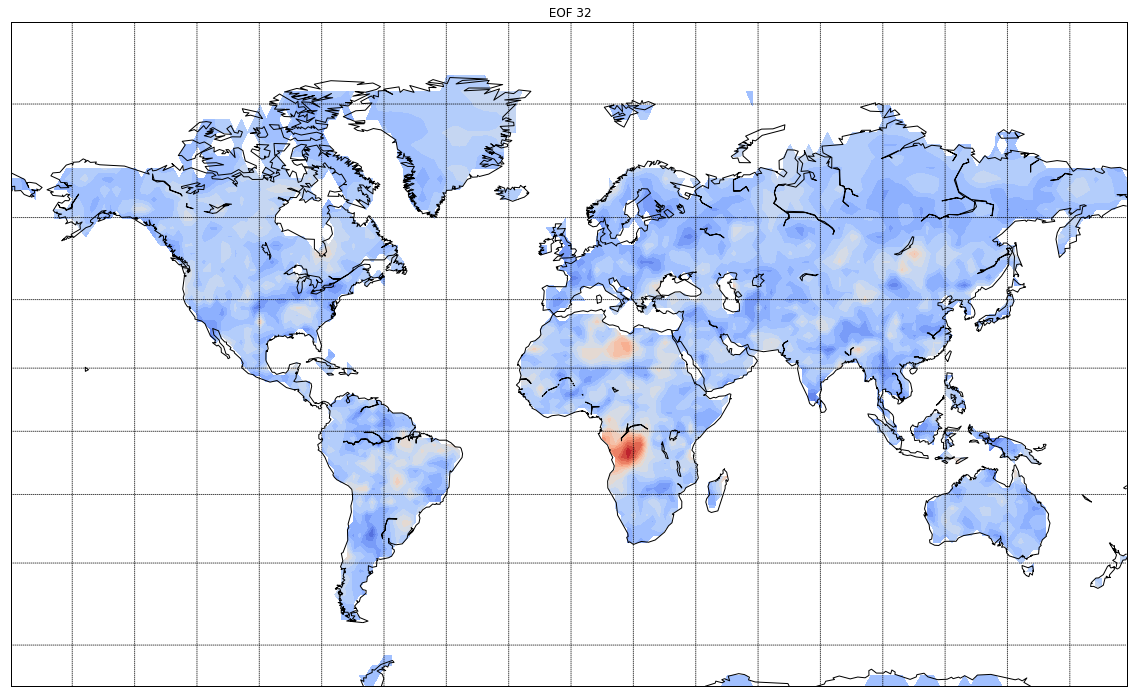

In [43]:
pc = 32

df_sst["pc"] = V[:,pc-1]

#lon1 = np.arange(-178.75,179.0,2.5)
lon1 = np.arange(-179.75,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat),len(lon1)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat[i]) & (df_sst.lons == lon1[j])].pc.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat[i]) & (df_sst.lons == lon1[j])].pc.values
        else:
            deg[i,j]=np.nan


#plt.figure(figsize=(30,15))

lon  = lon1
m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1.min(), \
  urcrnrlon=lon1.max(),llcrnrlat=lat.min()+20,urcrnrlat=lat.max(), \
  resolution='c')

lon2, lat2 = np.meshgrid(lon1,lat)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
cs = m.contourf(x,y,deg,20,cmap=plt.cm.get_cmap('coolwarm'))
plt.title(' EOF {}'.format(pc))
#cbar.ax.tick_params(labelsize=25)
#plt.colorbar();
plt.savefig("SOIL_EOF{}1.png".format(pc))

In [29]:
len(lon_list),len(lat_list)

(94111, 94111)

In [6]:
from global_land_mask import globe
import numpy as np

In [7]:
globe.is_land(lat_list[2], lon_list[2])

True

In [33]:
result = []
for i in range(len(lat_list)):
    result.append(globe.is_land(lat_list[i], lon_list[i]))

In [34]:
np.count_nonzero(result)

85689

In [40]:
result_sst[:,0]

matrix([[372.84778],
        [367.02182],
        [346.9139 ],
        [327.14737],
        [331.47806],
        [323.98013],
        [303.1031 ],
        [284.5177 ],
        [321.15018],
        [385.98315],
        [402.0567 ],
        [401.5088 ],
        [419.18018],
        [443.32513],
        [445.84262],
        [428.8904 ],
        [419.0152 ],
        [421.9927 ],
        [408.93005],
        [401.72717],
        [393.93445],
        [374.44284],
        [377.39682],
        [393.0201 ],
        [411.43863],
        [426.9647 ],
        [423.45496],
        [416.4711 ],
        [412.04254],
        [415.8931 ],
        [428.70697],
        [433.3601 ],
        [426.41272],
        [403.4461 ],
        [368.28006],
        [396.38593],
        [436.5295 ],
        [438.32547],
        [443.98444],
        [443.9693 ],
        [452.6552 ],
        [453.08115],
        [429.49292],
        [424.61063],
        [418.34155],
        [405.43793],
        [403.87384],
        [429.

In [35]:
result

[False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True

In [31]:
lon_list = np.array(lon_list)

In [32]:
lon_list[lon_list >= 180]=lon_list[lon_list >= 180] - 360

In [11]:
lon_list

array([ 0.25,  0.25,  0.25, ..., -0.25, -0.25, -0.25], dtype=float32)

In [15]:
result[:,1]

TypeError: list indices must be integers or slices, not tuple

In [18]:
lon_list[0], lat_list[0]

(0.25, 53.75)

In [5]:
d = Dataset('../../../nc/soilw.mon.mean.v2.nc')`

In [6]:
d.variables

OrderedDict([('lat', <class 'netCDF4._netCDF4.Variable'>
              float32 lat(lat)
                  long_name: Latitude
                  units: degrees_north
                  actual_range: [ 89.75 -89.75]
                  standard_name: latitude
                  axis: Y
                  coordinate_defines: point
              unlimited dimensions: 
              current shape = (360,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('lon', <class 'netCDF4._netCDF4.Variable'>
              float32 lon(lon)
                  long_name: Longitude
                  units: degrees_east
                  actual_range: [2.5000e-01 3.5975e+02]
                  standard_name: longitude
                  axis: X
                  coordinate_defines: point
              unlimited dimensions: 
              current shape = (720,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('soilw', <class 'netCDF4.